In [1]:
# Ajouter le dossier `src` au chemin de recherche Python
import sys
import os
sys.path.append(os.path.abspath('../src'))

# Importer la fonction `load_data` depuis le module `preprocess` dans `data_processing`
from data_processing.preprocessing import *
from utils.plotting import *
from tests_statistics.moments import *
from tests_statistics.jarque_bera import jarque_bera_test
from tests_statistics.ljung_box import ljung_box_test
from tests_statistics.autocorrelation import *
from data_processing.VaR import *

# Spécifier le chemin vers le fichier de données
filepath = '../data/raw/out12.csv'

# Charger les données
data = load_data(filepath)

Aperçu des données chargées :
   day      tick  logprice
0    1  0.002436  4.169607
1    1  0.002479  4.168214
2    1  0.002564  4.168214
3    1  0.003034  4.168214
4    1  0.003590  4.168524


In [2]:
# Vérifier les valeurs manquantes
check_missing_values(data)

Valeurs manquantes par colonne :
Series([], dtype: int64)


day         0
tick        0
logprice    0
dtype: int64

In [3]:
# Calcul des price 
price(data, log_price = 'logprice', return_column = 'Price')
data.head()

,day,tick,logprice,Price
0,1,0.002436,4.169607,64.69
1,1,0.002479,4.168214,64.60
2,1,0.002564,4.168214,64.60
3,1,0.003034,4.168214,64.60
4,1,0.003590,4.168524,64.62


In [4]:
# Calcul du simple return 
simple_return(data, price_column = 'Price', return_column = 'simple_return')
data.head()

,day,tick,logprice,Price,simple_return
0,1,0.002436,4.169607,64.69,NaN
1,1,0.002479,4.168214,64.60,-0.001391
2,1,0.002564,4.168214,64.60,0.000000
3,1,0.003034,4.168214,64.60,0.000000
4,1,0.003590,4.168524,64.62,0.000310


In [5]:
# Calcul du compounded return 
compounded_return(data, log_price_column = 'logprice', return_column = 'compounded_return')
data.head()

,day,tick,logprice,Price,simple_return,compounded_return
0,1,0.002436,4.169607,64.69,NaN,NaN
1,1,0.002479,4.168214,64.60,-0.001391,-0.001392
2,1,0.002564,4.168214,64.60,0.000000,0.000000
3,1,0.003034,4.168214,64.60,0.000000,0.000000
4,1,0.003590,4.168524,64.62,0.000310,0.000310


In [6]:
# Supprimer la première ligne
data = data.dropna()
data.head()

,day,tick,logprice,Price,simple_return,compounded_return
1,1,0.002479,4.168214,64.60,-0.001391,-0.001392
2,1,0.002564,4.168214,64.60,0.000000,0.000000
3,1,0.003034,4.168214,64.60,0.000000,0.000000
4,1,0.003590,4.168524,64.62,0.000310,0.000310
5,1,0.003675,4.168060,64.59,-0.000464,-0.000464


In [7]:
print(data['compounded_return'].describe())

count    1.615410e+06
mean    -1.364727e-06
std      7.446338e-04
min     -1.762480e-01
25%     -2.584313e-04
50%      0.000000e+00
75%      2.571686e-04
max      1.166369e-01
Name: compounded_return, dtype: float64


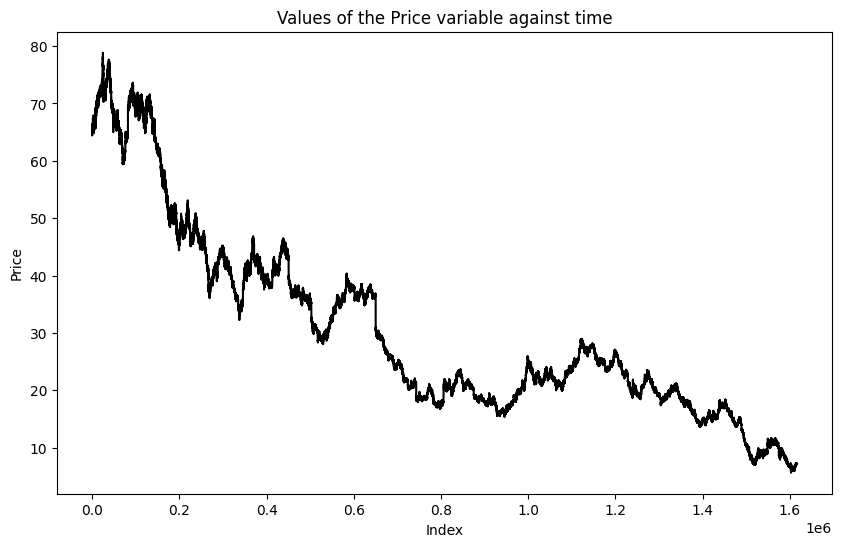

In [8]:
plot_price(data, return_column = 'Price')

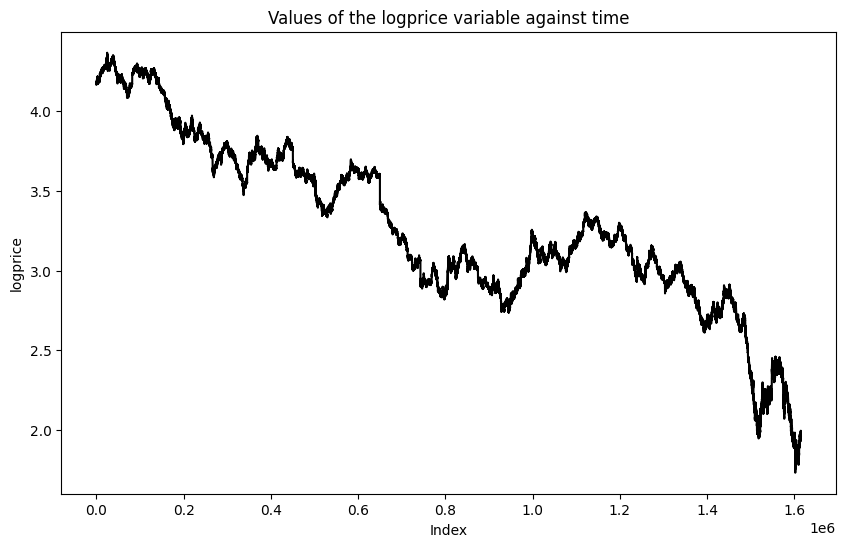

In [9]:
plot_price(data, return_column = 'logprice')

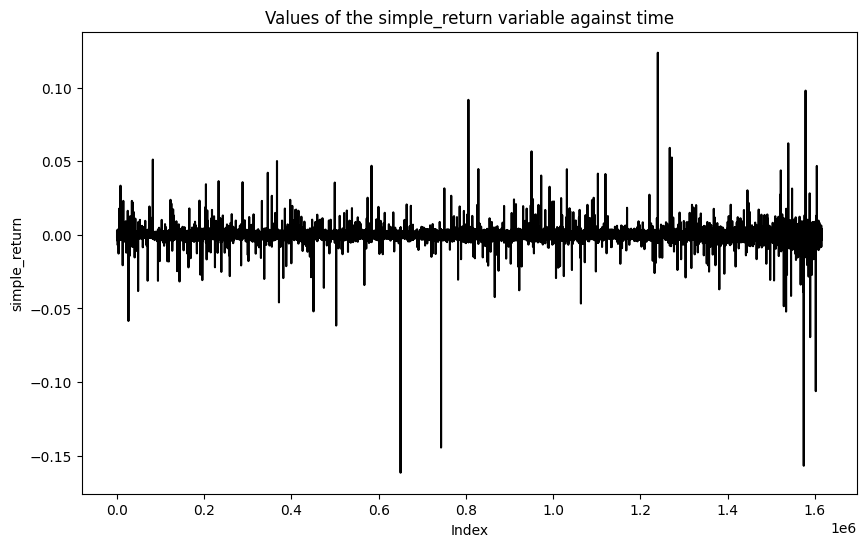

In [10]:
plot_return(data, return_column = 'simple_return')

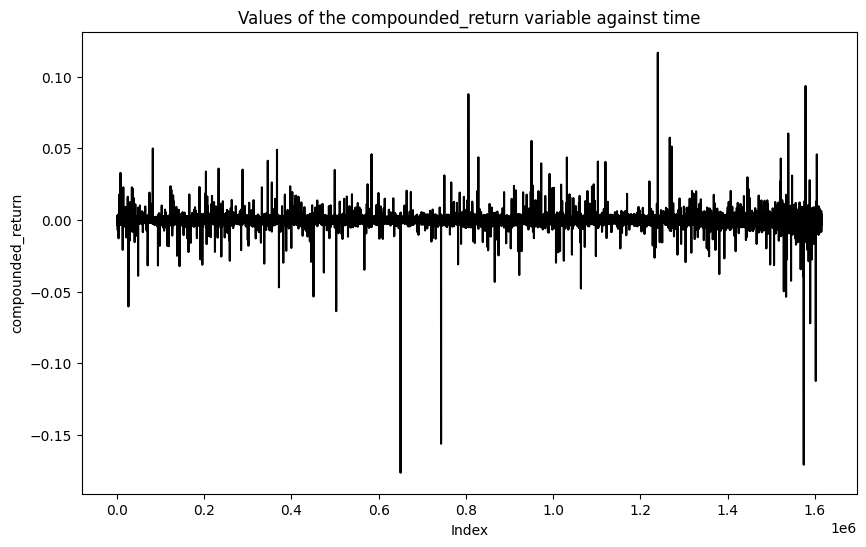

In [11]:
plot_return(data, return_column = 'compounded_return')

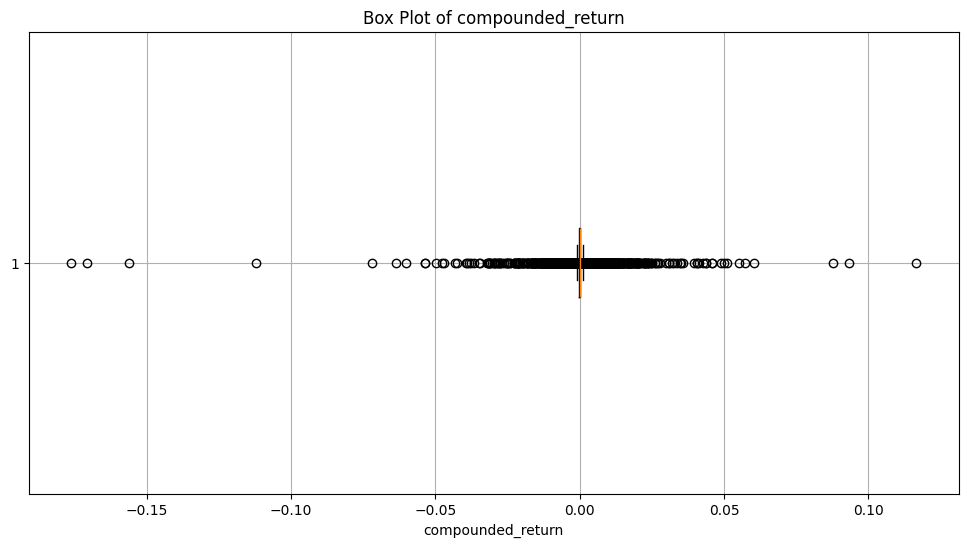

In [12]:
plot_boxplot(data, column = 'compounded_return')

In [13]:
# Calcul des statistiques
mean_value = empirical_mean(data, 'compounded_return')
variance_value = empirical_variance(data, 'compounded_return')
skewness_value = empirical_skewness(data, 'compounded_return')
kurtosis_value = empirical_kurtosis(data, 'compounded_return')

# Affichage des résultats
print(f"Empirical Mean: {mean_value}")
print(f"Empirical Variance: {variance_value}")
print(f"Empirical Skewness: {skewness_value}")
print(f"Empirical Kurtosis: {kurtosis_value}")


Empirical Mean: -1.364727455647231e-06
Empirical Variance: 5.544791283286485e-07
Empirical Skewness: -19.382784699148104
Empirical Kurtosis: 6307.563527054117


### Assumption of Data Frequency:
**Time Interval:**

To estimate the time interval between observations, we can divide the total duration of a trading day by the total number of observations. For example, a typical trading day in many markets lasts about 6.5 hours (e.g., from 9:30 AM to 4:00 PM in U.S. markets), which translates to 23,400 seconds.

Thus, the average time interval between observations can be calculated as:

$$
\Delta_t = \frac{23400 \text{ s}}{1638 \text{ obs}} \approx 14.3 \text{ s}
$$

This narrow time interval results in a mean of returns that is very close to zero and a relatively low variance. This low variance makes the returns particularly sensitive to extreme values, which can significantly influence the distributional measures.

Therefore, we will apply a filtering process to our dataset to remove outliers and mitigate this sensitivity to extreme values.

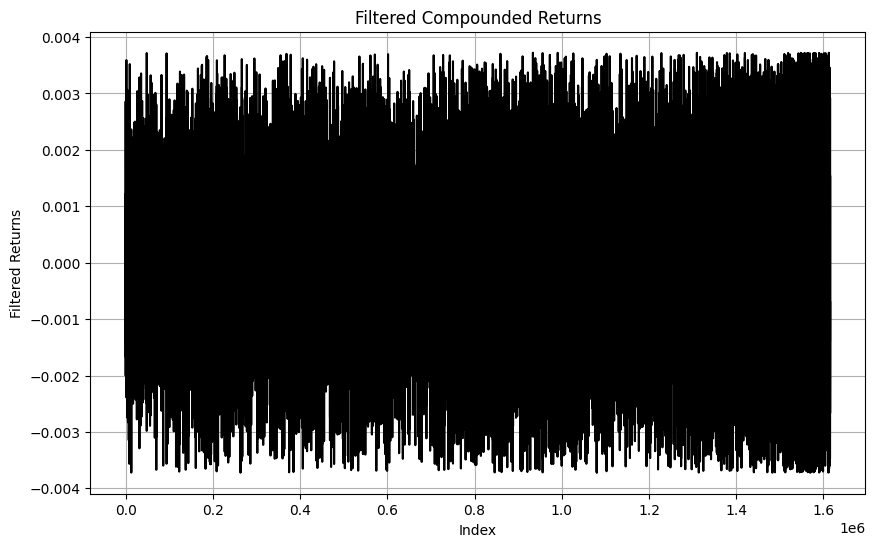

In [14]:
# Filtrer les valeurs aberrantes au-delà de ±5 écarts-types
filtered_data = data[(data['compounded_return'] >= -5 * data['compounded_return'].std()) &
                     (data['compounded_return'] <= 5 * data['compounded_return'].std())]

# Tracer à nouveau
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['compounded_return'], color='black')
plt.title('Filtered Compounded Returns')
plt.xlabel('Index')
plt.ylabel('Filtered Returns')
plt.grid(True)
plt.show()


In [15]:
mean_value = empirical_mean(filtered_data, 'compounded_return')
variance_value = empirical_variance(filtered_data, 'compounded_return')
skewness_value = empirical_skewness(filtered_data, 'compounded_return')
kurtosis_value = empirical_kurtosis(filtered_data, 'compounded_return')

print(f"Empirical Mean (filtered): {mean_value}")
print(f"Empirical Variance (filtered): {variance_value}")
print(f"Empirical Skewness (filtered): {skewness_value}")
print(f"Empirical Kurtosis (filtered): {kurtosis_value}")

Empirical Mean (filtered): -1.4387881804842498e-06
Empirical Variance (filtered): 3.216552702245234e-07
Empirical Skewness (filtered): -0.024444804064610234
Empirical Kurtosis (filtered): 8.369042409767946


These filtered results provide a more robust representation of the compounded_return distribution. The near-zero skewness and high kurtosis confirm that, while the data is generally symmetric, it still exhibits "fat tails," reflecting the presence of rare, significant deviations that are typical in high-frequency financial data. This underscores the importance of accounting for tail risk in financial models, as extreme events remain a key characteristic of the return distribution.

### Jarque-Bera Normality Test

Normality test : 
$$
H_0 : Normal dist., \quad H1 :different from Normal dist. 
$$
Under $H_0, \hat{Skew}, \hat{Kurt}$ are independent and asymptotically normal :
$$
\sqrt{n} \hat{Skew} \rightarrow_d \mathcal{N}(0,6), \quad \sqrt{n} \hat{Kurt}-3  \rightarrow_d \mathcal{N}(0,24)
$$

Jarque-Bera test statistic : Under $H_0$ as $n\rightarrow \infty$,
$$
JB = n \left(\frac{\hat{Skew}^2}{6}+ \frac{(\hat{Kurt}-3)^2}{24}\right)\rightarrow_d \chi^2(2)
$$

In [16]:
# Effectuer le test de Jarque-Bera sur la colonne 'compounded_return'
jb_results = jarque_bera_test(filtered_data, 'compounded_return')

# Afficher les résultats du test
print("Jarque-Bera Test Results:")
print(f"JB Statistic: {jb_results['JB Statistic']}")
print(f"p-value: {jb_results['p-value']}")
print(f"Normality: {jb_results['Normality']}")

Jarque-Bera Test Results:
JB Statistic: 1936497.2259412133
p-value: 0.0
Normality: Rejected


## Volatility

We call daily volatility of the asset, the standard deviation of the log-returns. 

If we observe price on T days, then we can estimate $\sigma_d$ by the square root of the empirical variance. 
$$
\sigma_d^2=\frac{1}{T} \sum_{i=1}^T R_t^2-(\bar R_t)^2
$$
where $\bar R_t = \frac{1}{T} \sum_{i=1}^T R_t$

In [17]:
# Calculer les moyennes journalières des rendements
daily_mean_returns = calculate_daily_mean_returns(filtered_data, day_column='day', return_column='compounded_return')
    
# Enregistrer les moyennes journalières dans le dossier processed
daily_mean_returns.to_csv('../data/processed/daily_mean_returns.csv', index=False)

print("Daily mean returns saved to 'data/processed/daily_mean_returns.csv'.")

Daily mean returns saved to 'data/processed/daily_mean_returns.csv'.


In [18]:
daily_mean_returns.describe()

,day,daily_mean_return
count,754.000000,754.000000
mean,377.500000,-0.000002
std,217.805341,0.000015
min,1.000000,-0.000067
25%,189.250000,-0.000010
50%,377.500000,-0.000002
75%,565.750000,0.000007
max,754.000000,0.000070


In [19]:
# Calculer les volatilités journalière, mensuelle et annualisée
volatility_results = calculate_volatility(daily_mean_returns, return_column='daily_mean_return')

# Afficher les résultats de volatilité
print("Volatility Results:")
print(f"Daily Volatility: {volatility_results['daily_volatility']}")
print(f"Monthly Volatility: {volatility_results['monthly_volatility']}")
print(f"Annualized Volatility: {volatility_results['annualized_volatility']}")

Volatility Results:
Daily Volatility: 1.4577684889564671e-05
Monthly Volatility: 4.208215147575852e-06
Annualized Volatility: 0.0002314135734531132


These volatility results indicate a relatively stable asset with low levels of fluctuation over time. For investors or analysts, such a low annualized volatility would imply lower expected risk, which may be attractive for risk-averse strategies but could also mean lower potential returns, as higher returns often accompany higher volatility. If the dataset represents high-frequency or intraday data, this stable profile suggests that external factors may have limited influence on price movement within the observed periods.

## Assumptions on the returns

The assumptions on the returns are that : 
- returns follow a normal distribution
- returns are independent over time
- the distribution of the returns does not change over time

We are going to check all these assumptions before computing the VaR. 
As seen before, the compounded return does not follow the normal distribution. We will try the Jarque Bera test to check if the daily mean returns follows the normal distribution. 

### Check normal distribution using jarque Bera test

In [20]:
# Effectuer le test de Jarque-Bera sur la colonne 'compounded_return'
jb_results = jarque_bera_test(filtered_data, 'compounded_return')

# Afficher les résultats du test
print("Jarque-Bera Test Results:")
print(f"JB Statistic: {jb_results['JB Statistic']}")
print(f"p-value: {jb_results['p-value']}")
print(f"Normality: {jb_results['Normality']}")

Jarque-Bera Test Results:
JB Statistic: 1936497.2259412133
p-value: 0.0
Normality: Rejected


### Check autocorellation over time 



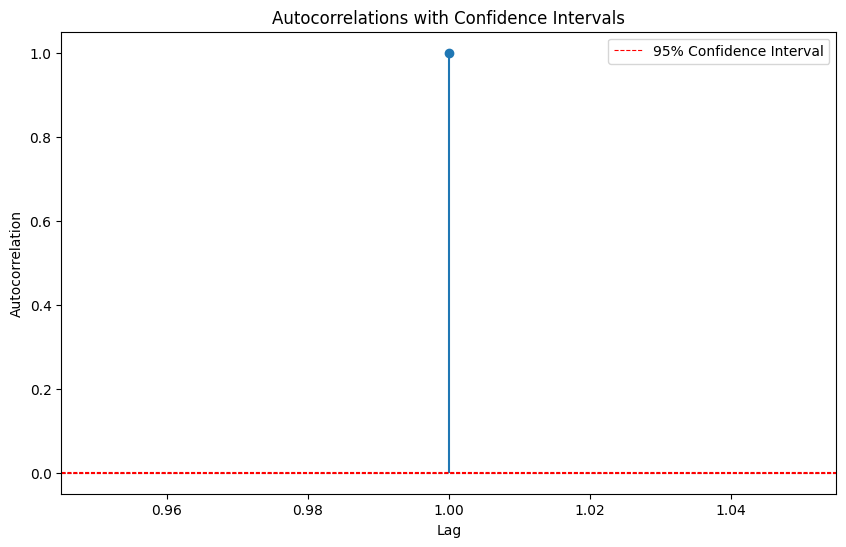

In [21]:
plot_autocorrelations_with_ci(filtered_data['compounded_return'], max_lag=1, alpha=0.05)

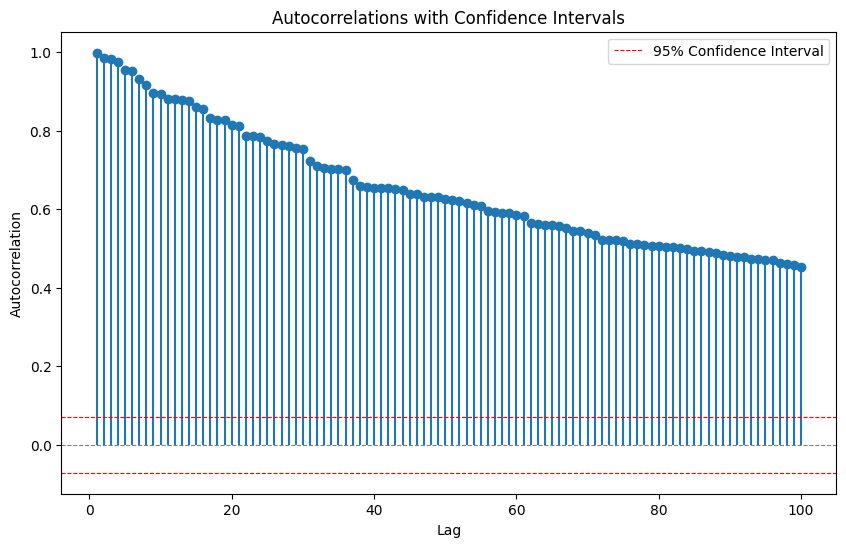

In [22]:
plot_autocorrelations_with_ci(daily_mean_returns['daily_mean_return'], max_lag=100, alpha=0.05)


**Ljung_Box on all the log_return**

In [23]:
# Test de Ljung-Box
result_all = ljung_box_test(filtered_data['compounded_return'], lags=20)

# Afficher les résultats
print("Ljung-Box Test Results:")
print(f"Q-Statistic: {result_all['Q-Statistic']}")
print(f"p-value: {result_all['p-value']}")
print(f"Conclusion: {result_all['Conclusion']}")
print(f"Autocorrelations: {result_all['Autocorrelations']}")

Ljung-Box Test Results:
Q-Statistic: 10465.360881808005
p-value: 0.0
Conclusion: Significant autocorrelation
Autocorrelations: [0.07990506888273391, 0.005751833213245009, -0.00452896041974913, -0.004137636869063914, -0.002091636446685591, -0.0017910006147170664, -0.0037892470340554207, -9.525134623637556e-05, -0.0004224312952410191, -0.0005052571358911864, 0.0014235550076442886, 0.0010406570676928175, -0.0007209211209748523, 0.0005510811765921559, 0.00042259352778644993, -0.0005992450180851207, -0.00029980526989514757, 0.001674960440956226, -0.001364952036281467, 0.002121230547286978]


**Ljung_Box test on daily_mean_return**

In [24]:
# Test de Ljung-Box
result_daily = ljung_box_test(filtered_data['compounded_return'], lags=20)

# Afficher les résultats
print("Ljung-Box Test Results:")
print(f"Q-Statistic: {result_daily['Q-Statistic']}")
print(f"p-value: {result_daily['p-value']}")
print(f"Conclusion: {result_daily['Conclusion']}")
print(f"Autocorrelations: {result_daily['Autocorrelations']}")

Ljung-Box Test Results:
Q-Statistic: 10465.360881808005
p-value: 0.0
Conclusion: Significant autocorrelation
Autocorrelations: [0.07990506888273391, 0.005751833213245009, -0.00452896041974913, -0.004137636869063914, -0.002091636446685591, -0.0017910006147170664, -0.0037892470340554207, -9.525134623637556e-05, -0.0004224312952410191, -0.0005052571358911864, 0.0014235550076442886, 0.0010406570676928175, -0.0007209211209748523, 0.0005510811765921559, 0.00042259352778644993, -0.0005992450180851207, -0.00029980526989514757, 0.001674960440956226, -0.001364952036281467, 0.002121230547286978]


## Stationarity test 

/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


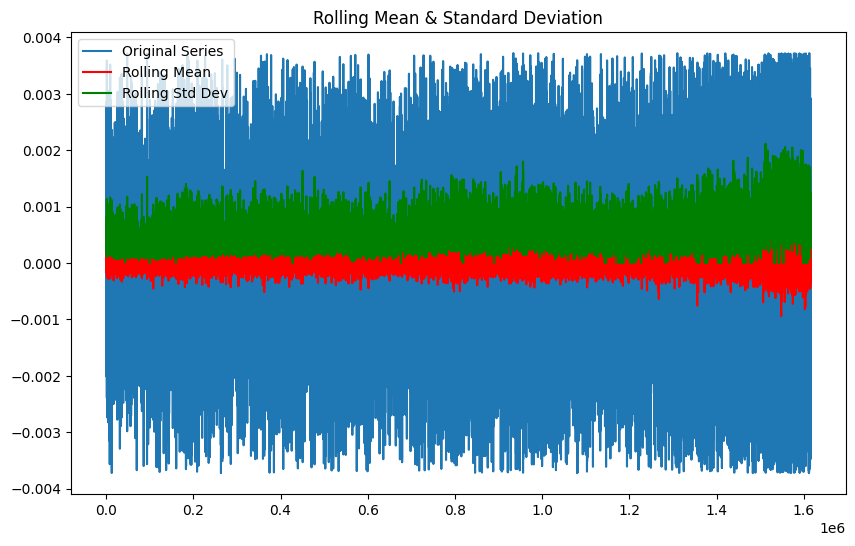

In [25]:
# Moyenne glissante et variance glissante
rolling_mean = filtered_data['compounded_return'].rolling(window=50).mean()
rolling_std = filtered_data['compounded_return'].rolling(window=50).std()

# Tracer
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['compounded_return'], label="Original Series")
plt.plot(rolling_mean, label="Rolling Mean", color="red")
plt.plot(rolling_std, label="Rolling Std Dev", color="green")
plt.legend()
plt.title("Rolling Mean & Standard Deviation")
plt.show()

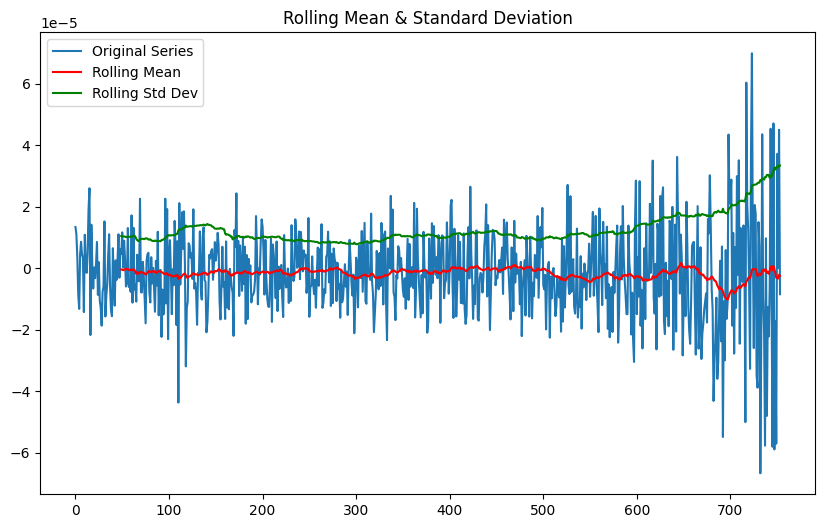

In [26]:
# Moyenne glissante et variance glissante
rolling_mean = daily_mean_returns['daily_mean_return'].rolling(window=50).mean()
rolling_std = daily_mean_returns['daily_mean_return'].rolling(window=50).std()

# Tracer
plt.figure(figsize=(10, 6))
plt.plot(daily_mean_returns['daily_mean_return'], label="Original Series")
plt.plot(rolling_mean, label="Rolling Mean", color="red")
plt.plot(rolling_std, label="Rolling Std Dev", color="green")
plt.legend()
plt.title("Rolling Mean & Standard Deviation")
plt.show()

This graph suggests that compounded_return seems stationary in mean and variance :

- The mean stays constant around zero
- The variance does not change significantly over time

However, we need to make statistical test to conclude about the stationarity

In [27]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(filtered_data['compounded_return'].sample(100000).dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
if result[1] <= 0.05:
    print("La série est stationnaire (on rejette H0).")
else:
    print("La série n'est pas stationnaire (on ne rejette pas H0).")


ADF Statistic: -141.22458326636917
p-value: 0.0
La série est stationnaire (on rejette H0).


In [28]:
from statsmodels.tsa.stattools import kpss

# Test KPSS sur un sous-échantillon
result_kpss = kpss(filtered_data['compounded_return'].sample(100000).dropna(), regression='c')

# Afficher les résultats
print(f"KPSS Statistic: {result_kpss[0]}")
print(f"p-value: {result_kpss[1]}")
for key, value in result_kpss[3].items():
    print(f"Critical Value ({key}): {value}")

# Conclusion
if result_kpss[1] > 0.05:
    print("La série est stationnaire (on ne rejette pas H0).")
else:
    print("La série n'est pas stationnaire (on rejette H0).")


KPSS Statistic: 0.08370054131160436
p-value: 0.1
Critical Value (10%): 0.347
Critical Value (5%): 0.463
Critical Value (2.5%): 0.574
Critical Value (1%): 0.739
La série est stationnaire (on ne rejette pas H0).


/var/folders/st/r4516zk90q99jmp6fk3fn3nc0000gn/T/ipykernel_12381/565787782.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss = kpss(filtered_data['compounded_return'].sample(100000).dropna(), regression='c')


### Ce que cela signifie

- KPSS Statistic très faible :
La valeur 0.096 est bien en dessous des valeurs critiques fournies (0.347 pour 10%).

**Cela indique que l'hypothèse nulle (H0)  : stationnarité est fortement soutenue.**

- p-value approximative :
La p-valeur réelle est supérieure à 0.1, mais comme la table utilisée dans l'implémentation KPSS est limitée à p≤0.1, l'avertissement est généré.

**The fact that the series of the compounded returns is stationary allows us to use models such as ARIMA or GARCH**

### Nonparametric estimation of the distribution function: IID

Let $x_1, \cdots, x_n$ are iid realisations of a random variable X. Then, 
$$
F_n(c) = \frac{1}{n} \sum_{i=1}^{n} I(x_i \leq c)
$$
where $I(.)$ is an indicator function. 

Let $x_{(1)}, \cdots, x_{(n)}$ be the ordered data. For a significance level of $1-\alpha$, let $m = \lfloor na \rfloor$, the largest integer smaller than or equal to $n\alpha$. Then
$$
F_n(X \leq x_{(m)}) = \frac{m}{n} \approx \alpha
$$


### Empirical VaR under IID 

In [29]:
alpha = 0.05  # 95% confidence level
VaR = empirical_var(filtered_data['compounded_return'].values, alpha)
print(f"VaR (95% confidence level): {VaR}")

VaR (95% confidence level): -0.000893965790849105


### Nonparametric estimation of VaR under IID

**Assumption**: Future distribution of the returns can be estimated from information in the data to the present $\Rightarrow X_t$ are IID

**We consider that the logreturn are i.i.d**

### Estimating VaR for  $\alpha \approx 0 $

- For a very small $\alpha$, too few observations above the threshold (increasing variance)
- Estimator not defined when $\alpha < \frac{1}{n}$
- Observations are often heavy-tailed

A Pareto-type model for tail of the distribution : for a low threshold $u<0$, assume 
$$
P(X<x) \approx \frac{-c}{(-x)^\gamma}, \quad c >0, \gamma >0, x<u
$$

Thickness of the tail = $\mathbb{E}[|X|^k]<\infty$ for $k<\gamma$. How to estimate the tail index $\gamma$? 

The relation (1) implies that $P(X<x|X<u)\approx (-u)^\gamma/ (-x)^\gamma \quad \text{for} x<u$

### Hill estimator of tail index $\gamma$

Assume that the Pareto model is exact. Then the conditional density is
$$
f(x|X<u)= \gamma(-u)^\gamma (-x)^{-(\gamma+1)}, \quad x<u
$$

Assume that there are $n_u$ observations below the threshold $u$. Then the MLE of $\gamma$ as 
$$
\hat\gamma = \left[\frac{1}{n_u} \sum_{i=1}^{n_u} \{log(-x_{(i)})- log(-u)\right]^{-1}
$$

Often the threshold $u$ is actually taken to be the $k$th order statistic, $X_{(k)}$, which involves the bias-variance trade-off. 

### Estimation of VaR

Estimation of c can be performed by matching the theoretical and empirical proportions: 
$$
P(X<u) = \frac{-c}{(-u)^\gamma}=\frac{m}{n}, \quad -\hat c = \frac{n_u}{n}(-u)^{\hat\gamma}
$$

Plugging into the Pareto model provides an etimate of high quantiles
$$
P(X<x_\alpha) = \frac{-c}{(-x_\alpha)^{\hat\gamma}}= \alpha
$$

The estimation of $VaR(\alpha)$ is then 
$$
\hat{VaR}(\alpha)= \hat{x_\alpha}= u \left(\frac{n_u}{n \alpha}\right)^{\frac{1}{\hat\gamma}}
$$

In [34]:
# Exemple d'utilisation
threshold = np.percentile(data, 5)  # For example, set u to the 5th percentile
print(f"Threshold: {threshold}")
alpha = 0.05       # 99% confidence level
data = filtered_data['compounded_return'].values

VaR_pareto = pareto_var(data, alpha, threshold)
print(f"VaR (Pareto, 95% confidence level): {VaR_pareto}")

Threshold: -0.0008939619853625123
VaR (Pareto, 95% confidence level): 0.0008939653060778305


### Assess the IID Hypothesis
To validate the IID assumption, you need to:

In [37]:
lb_test = ljung_box_test(filtered_data['compounded_return'].sample(100000).dropna(), lags=20)
print(lb_test)

{'Q-Statistic': 14.542272368152616, 'p-value': 0.8019726671240633, 'Conclusion': 'No significant autocorrelation', 'Autocorrelations': [0.0017608550142447223, -0.00027350015728776623, -0.0021727997146773507, 0.0026092725808489936, -0.0013974145225563064, -0.0006046334716991966, -0.0005319149398510609, 0.0037443897347291836, 0.003771136054256911, -0.00044547466369113727, -0.0058180324839952734, 0.0012158192348513189, 0.0019197206727409502, 0.004548524929518726, -0.0005819864209515251, -0.0013645892464824528, -0.002031918978600785, 0.0037184085338496245, 0.001228774553280349, 0.004276393134348063]}


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(filtered_data['compounded_return'].dropna(), lags=20, title="Full Dataset ACF")
plot_acf(filtered_data['compounded_return'].sample(100000).dropna(), lags=20, title="Sample ACF")
plt.show()